# Training Rotnet with cifar10

In [1]:
# Google Colab setup 1
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/ECE661/Final Project/Tego_dev'

Mounted at /content/drive
/content/drive/My Drive/ECE661/Final Project/Tego_dev


In [2]:
# Google Colab setup 2
import zipfile as zf

files = zf.ZipFile("tools.zip", 'r')
files.extractall('./')
files.close()

In [3]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Data Augmentation

### Rotation Visualization


In [4]:
# Preparing 4 different image rotations
import torchvision
import torchvision.transforms as transforms

print('==> Preparing data..')

rotater_0 = transforms.Compose([
    transforms.ToTensor(),
])

rotater_90 = transforms.Compose([
    transforms.RandomRotation(degrees=(90, 90)),
    transforms.ToTensor(),
])

rotater_180 = transforms.Compose([
    transforms.RandomRotation(degrees=(180, 180)),
    transforms.ToTensor()
])


rotater_270 = transforms.Compose([
    transforms.RandomRotation(degrees=(270, 270)),
    transforms.ToTensor(),
])

==> Preparing data..


In [5]:
class AugmentationRotations(object):
    def __init__(self, rotation_0, rotation_90, rotation_180, rotation_270):
        self.rotation_0 = rotation_0
        self.rotation_90 = rotation_90
        self.rotation_180 = rotation_180
        self.rotation_270 = rotation_270

    def __call__(self, x):
        # print (torch.stack([self.rotation_0(x), self.rotation_90(x), self.rotation_180(x), self.rotation_270(x)]).view(-1, 3, 32, 32).size())
        # return torch.stack([self.rotation_0(x), self.rotation_90(x), self.rotation_180(x), self.rotation_270(x)]).view(-1, 3, 32, 32)
        return [self.rotation_0(x), self.rotation_90(x), self.rotation_180(x), self.rotation_270(x)]


    # def __init__(self, base_transforms):
    #     self.base_transforms = base_transforms

    # def __call__(self, x):
    #     return self.base_transforms(x)

In [6]:
aug_rotation = torchvision.datasets.CIFAR10(root='./data_rotation', 
                                            train=True, 
                                            download=True,
                                            transform=AugmentationRotations(rotater_0, 
                                                                            rotater_90, 
                                                                            rotater_180, 
                                                                            rotater_270))

Files already downloaded and verified


In [7]:
## visualizing 6 sets of image (each image with 2 augmentation)

NUM_IMAGES = 6

imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in aug_rotation[idx][0]], dim=0)
img_grid_0 = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, pad_value=0.9)
img_grid_0 = img_grid_0.permute(1, 2, 0) # permute and make sure the color channel is the last one

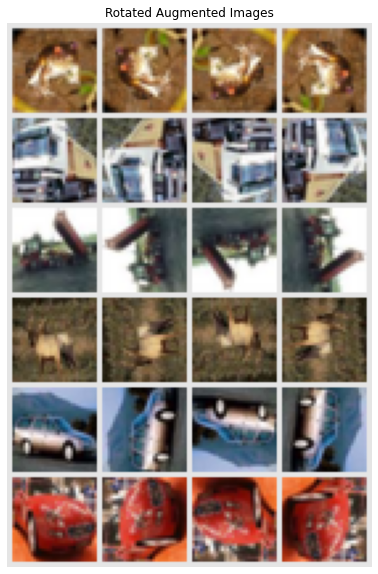

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(figsize=(10,10))
axs.imshow(img_grid_0)
axs.set_title("Rotated Augmented Images")
axs.axis('off')

plt.show()

### Data Loader

In [9]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose(
    [
    # transforms.Pad(padding=4), 
    transforms.RandomCrop(size=(32, 32), padding=4), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

transform_val = transforms.Compose(
    [
    # transforms.Pad(padding=4), 
    transforms.RandomCrop(size=(32, 32), padding=4), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

In [10]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train    # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val    # your code
)

# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=TRAIN_BATCH_SIZE,  # your code
    shuffle=True,     # your code
    num_workers=4
)
                                          
val_loader = DataLoader(
    val_set, 
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle=False,     # your code
    num_workers=4
)

Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


### Rotation Versions in Data Augmentation

In [11]:
# # Data preprocessing
# import torchvision
# import torchvision.transforms as transforms

# transform_train_rot0 = transforms.Compose(
#     [
#     # transforms.Pad(padding=4), 
#     transforms.RandomCrop(size=(32, 32), padding=4), 
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])

# transform_train_rot90 = transforms.Compose(
#     [
#     # transforms.Pad(padding=4), 
#     transforms.RandomCrop(size=(32, 32), padding=4), 
#     transforms.RandomRotation(degrees=(90, 90)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])

# transform_train_rot180 = transforms.Compose(
#     [
#     # transforms.Pad(padding=4), 
#     transforms.RandomCrop(size=(32, 32), padding=4), 
#     transforms.RandomRotation(degrees=(180, 180)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])

# transform_train_rot270 = transforms.Compose(
#     [
#     # transforms.Pad(padding=4), 
#     transforms.RandomCrop(size=(32, 32), padding=4), 
#     transforms.RandomRotation(degrees=(270, 270)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])

# transform_val_rot0 = transforms.Compose(
#     [
#     # transforms.Pad(padding=4), 
#     transforms.RandomCrop(size=(32, 32), padding=4), 
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])

# transform_val_rot90 = transforms.Compose(
#     [
#     # transforms.Pad(padding=4), 
#     transforms.RandomCrop(size=(32, 32), padding=4), 
#     transforms.RandomRotation(degrees=(90, 90)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])

# transform_val_rot180 = transforms.Compose(
#     [
#     # transforms.Pad(padding=4), 
#     transforms.RandomCrop(size=(32, 32), padding=4), 
#     transforms.RandomRotation(degrees=(180, 180)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])

# transform_val_rot270 = transforms.Compose(
#     [
#     # transforms.Pad(padding=4), 
#     transforms.RandomCrop(size=(32, 32), padding=4), 
#     transforms.RandomRotation(degrees=(270, 270)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])

In [12]:
# # Downloading the dataset
# from tools.dataset import CIFAR10
# from torch.utils.data import DataLoader

# # a few arguments, do NOT change these
# DATA_ROOT = "./data"
# TRAIN_BATCH_SIZE = 256
# VAL_BATCH_SIZE = 100

# #############################################
# # your code here
# # construct dataset
# train_set = CIFAR10(
#     root=DATA_ROOT, 
#     mode='train', 
#     download=True,
#     transform=AugmentationRotations(transform_train_rot0, 
#                                     transform_train_rot90,
#                                     transform_train_rot180,
#                                     transform_train_rot270)    # your code
#     # target_transform = AugmentationRotations(transform_train_rot0, 
#     #                                         transform_train_rot90,
#     #                                         transform_train_rot180,
#     #                                         transform_train_rot270)
# )
# val_set = CIFAR10(
#     root=DATA_ROOT, 
#     mode='val', 
#     download=True,
#     transform=AugmentationRotations(transform_val_rot0, 
#                                     transform_val_rot90,
#                                     transform_val_rot180,
#                                     transform_val_rot270)    # your code
#     # target_transform = AugmentationRotations(transform_val_rot0, 
#     #                                 transform_val_rot90,
#     #                                 transform_val_rot180,
#     #                                 transform_val_rot270)
# )

# # train_set_rot0 = CIFAR10(
# #     root=DATA_ROOT, 
# #     mode='train', 
# #     download=True,
# #     transform=AugmentationRotations(transform_train_rot0)    # your code
# # )
# # val_set_rot0 = CIFAR10(
# #     root=DATA_ROOT, 
# #     mode='val', 
# #     download=True,
# #     transform=AugmentationRotations(transform_val_rot0)    # your code
# # )

# # train_set_rot90 = CIFAR10(
# #     root=DATA_ROOT, 
# #     mode='train', 
# #     download=True,
# #     transform=AugmentationRotations(transform_train_rot90)    # your code
# # )
# # val_set_rot90 = CIFAR10(
# #     root=DATA_ROOT, 
# #     mode='val', 
# #     download=True,
# #     transform=AugmentationRotations(transform_val_rot90)    # your code
# # )

# # train_set_rot180 = CIFAR10(
# #     root=DATA_ROOT, 
# #     mode='train', 
# #     download=True,
# #     transform=AugmentationRotations(transform_train_rot180)    # your code
# # )
# # val_set_rot180 = CIFAR10(
# #     root=DATA_ROOT, 
# #     mode='val', 
# #     download=True,
# #     transform=AugmentationRotations(transform_val_rot180)    # your code
# # )

# # train_set_rot270 = CIFAR10(
# #     root=DATA_ROOT, 
# #     mode='train', 
# #     download=True,
# #     transform=AugmentationRotations(transform_train_rot270)    # your code
# # )
# # val_set_rot270 = CIFAR10(
# #     root=DATA_ROOT, 
# #     mode='val', 
# #     download=True,
# #     transform=AugmentationRotations(transform_val_rot270)    # your code
# # )

# # # train_set = torch.stack([train_set_rot0, train_set_rot90, train_set_rot180, train_set_rot270])
# # train_set = torch.utils.data.ConcatDataset([train_set_rot0, train_set_rot90, train_set_rot180, train_set_rot270])

# # # val_set = torch.stack([val_set_rot0, val_set_rot90, val_set_rot180, val_set_rot270])
# # val_set = torch.utils.data.ConcatDataset([val_set_rot0, val_set_rot90, val_set_rot180, val_set_rot270])


# # construct dataloader
# train_loader = DataLoader(
#     train_set, 
#     batch_size=TRAIN_BATCH_SIZE,  # your code
#     shuffle=True,     # your code
#     num_workers=4
# )
                                          
# val_loader = DataLoader(
#     val_set, 
#     batch_size=VAL_BATCH_SIZE,  # your code
#     shuffle=False,     # your code
#     num_workers=4
# )
# #############################################

## Network Architecture - Rotnet

In [30]:
class RotBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super(RotBlock, self).__init__()
        padding = int((kernel_size - 1) / 2) # adding this make acc increase from 0.25 to 0.6 up
        self.conv = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size, padding=padding),
            nn.BatchNorm2d(out_planes), # adding this make acc increase from 0.25 to 0.6 up
            nn.ReLU(True)
        )
    def forward(self, x):
        return self.conv(x)

In [ ]:
# separate first 2 block and the last two: refer to to net_f & net_g

In [31]:
class RotNN(nn.Module):
    def __init__(self, num_classes = 4, num_inchannels = 3):
        super(RotNN, self).__init__()
        
# RuntimeError: Given groups=1, weight of size [192, 3, 5, 5], 
# expected input[512, 96, 28, 28] to have 3 channels, but got 96 channels instead

        n_channels = 192
        n_channels2 = 160
        n_channels3 = 96

        # # 1st block
        # blocks[0].add_module("Block1_ConvB1", BasicBlock(num_inchannels, n_channels, 5))
        # blocks[0].add_module("Block1_ConvB2", BasicBlock(n_channels, n_channels2, 1))
        # blocks[0].add_module("Block1_ConvB3", BasicBlock(n_channels2, n_channels3, 1))
        # blocks[0].add_module(
        #     "Block1_MaxPool", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # )

        self.mlpconv1_1 = RotBlock(num_inchannels, n_channels, 5)
        self.mlpconv1_2 = RotBlock(n_channels, n_channels2, 1)
        self.mlpconv1_3 = RotBlock(n_channels2, n_channels3, 1)
        # optional: add max pooling at the end of each block

        # # 2nd block
        # blocks[1].add_module("Block2_ConvB1", BasicBlock(n_channels3, n_channels, 5))
        # blocks[1].add_module("Block2_ConvB2", BasicBlock(n_channels, n_channels, 1))
        # blocks[1].add_module("Block2_ConvB3", BasicBlock(n_channels, n_channels, 1))
        # blocks[1].add_module(
        #     "Block2_AvgPool", nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        # )

        self.mlpconv2_1 = RotBlock(n_channels3, n_channels, 5)
        self.mlpconv2_2 = RotBlock(n_channels, n_channels, 1)
        self.mlpconv2_3 = RotBlock(n_channels, n_channels, 1)

        # # 3rd block
        # blocks[2].add_module("Block3_ConvB1", BasicBlock(n_channels, n_channels, 3))
        # blocks[2].add_module("Block3_ConvB2", BasicBlock(n_channels, n_channels, 1))
        # blocks[2].add_module("Block3_ConvB3", BasicBlock(n_channels, n_channels, 1))

        self.mlpconv3_1 = RotBlock(n_channels, n_channels, 3)
        self.mlpconv3_2 = RotBlock(n_channels, n_channels, 1)
        self.mlpconv3_3 = RotBlock(n_channels, n_channels, 1)

        self.mlpconv4_1 = RotBlock(n_channels, n_channels, 3)
        self.mlpconv4_2 = RotBlock(n_channels, n_channels, 1)
        self.mlpconv4_3 = RotBlock(n_channels, n_channels, 1)

        self.fc1 = nn.Linear(n_channels, num_classes)

    def forward(self, x):
        out = self.mlpconv1_3(self.mlpconv1_2(self.mlpconv1_1(x)))
        out = self.mlpconv2_3(self.mlpconv2_2(self.mlpconv2_1(out)))
        out = self.mlpconv3_3(self.mlpconv3_2(self.mlpconv3_1(out)))
        out = self.mlpconv4_3(self.mlpconv4_2(self.mlpconv4_1(out)))

        out = F.avg_pool2d(out, (out.size(2), out.size(3))).view(-1, out.size(1)) #  GlobalAveragePooling
        # alternative: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
        out = self.fc1(out)
        return out

## Training Pipeline


In [15]:
# specify the device for computation

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# net.to(device)

cuda:0


In [16]:
# # initial learning rate
# INITIAL_LR = 0.1 # 0.01 

# # momentum for optimizer
# MOMENTUM = 0.9

# # L2 regularization strength
# REG = 1e-4

# # create loss function
# criterion = nn.CrossEntropyLoss()

# # Add optimizer
# optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM)

In [17]:
transform_train_rot90 = transforms.Compose(
    [
    transforms.ToPILImage(),
    # transforms.Pad(padding=4), 
    transforms.RandomCrop(size=(32, 32), padding=4), 
    transforms.RandomRotation(degrees=(90, 90)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

transform_train_rot180 = transforms.Compose(
    [
    transforms.ToPILImage(),
    # transforms.Pad(padding=4), 
    transforms.RandomCrop(size=(32, 32), padding=4), 
    transforms.RandomRotation(degrees=(180, 180)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

transform_train_rot270 = transforms.Compose(
    [
    transforms.ToPILImage(),
    # transforms.Pad(padding=4), 
    transforms.RandomCrop(size=(32, 32), padding=4), 
    transforms.RandomRotation(degrees=(270, 270)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])


In [32]:
# import pandas as pd
import numpy as np

# some hyperparameters
# total number of training epochs
# EPOCHS = 30

# current_learning_rate = INITIAL_LR
epoch_acc_decay = []
# WARMUP_EPOCHS= 100
# WARMUPED_LR = 0.1
DECAY_EPOCHS = [30, 60, 80]# 50
DECAY = 0.2

def train_valid (net, EPOCHS, criterion, optimizer, current_learning_rate, current_reg_l2)-> float:
    # start the training/validation process
    # the process should take about 5 minutes on a GTX 1070-Ti
    # if the code is written efficiently.
    best_val_acc = 0
    # the folder where the trained model is saved
    CHECKPOINT_FOLDER = "./saved_model_resnet"
    
    print("==> Training starts!")
    print("="*50)
    for i in range(0, EPOCHS):
        # handle the learning rate scheduler.
        # if i % WARMUP_EPOCHS == 0 and i != 0:
        #     current_learning_rate = WARMUPED_LR   
        #     print("Current learning rate has increased to %f" %current_learning_rate)

        # if i % DECAY_EPOCHS == 0 and i > WARMUP_EPOCHS:
        if i in DECAY_EPOCHS:
            current_learning_rate = current_learning_rate * DECAY
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_learning_rate
            print("Current learning rate has decayed to %f" %current_learning_rate)
        
        #######################
        # your code here
        # switch to train mode
        net.train()
        
        #######################
        
        print("Epoch %d:" %i)
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0

        train_loss = 0 # track training loss if you want
        
        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader): 
            # copy inputs to device            
            # inputs, targets = inputs.to(device), targets.to(device)
            # print ("batch_idx: ", batch_idx)
            # print ("type(inputs): ", type(inputs))
            # print ("input.size(): ", inputs.size())
            # print ("type(targets): ", type(targets))
            # print ("len(targets)", len(targets))
            # print ("targets: ", targets)

            # transform inputs into 4 rotation versions: 0, 90, 180, 270
            for ind_img in range(len(inputs)): # loop through each image in batch 
                input_rot0 = inputs[ind_img]
                input_rot90 = transform_train_rot90(inputs[ind_img])
                input_rot180 = transform_train_rot180(inputs[ind_img])
                input_rot270 = transform_train_rot270(inputs[ind_img])

                # resize 
                input_rot0, input_rot90, input_rot180, input_rot270 = torch.unsqueeze(input_rot0, 0), \
                                                                      torch.unsqueeze(input_rot90, 0), \
                                                                      torch.unsqueeze(input_rot180, 0), \
                                                                      torch.unsqueeze(input_rot270, 0)
                # if this is the first image in the batch, we just concat the 2 data aug 
                if ind_img == 0:
                    total_tensor = torch.cat((input_rot0, input_rot90, input_rot180, input_rot270), dim=0)
                    rot_labels = torch.tensor([0, 1, 2, 3]) 
                # else append to the previous augmented pair in the batch 
                else:
                    total_tensor = torch.cat((total_tensor, input_rot0, input_rot90, input_rot180, input_rot270), dim=0)            
                    rot_labels = torch.cat((rot_labels, torch.tensor([0, 1, 2, 3])), dim=0) 

            total_tensor, rot_labels = total_tensor.to(device), rot_labels.to(device)
            # print ("total_tensor.size(): ", total_tensor.size())
            # print ("rot_labels.size(): ", rot_labels.size())
              
            # compute the output and loss
            # outputs = net(inputs)
            outputs = net(total_tensor)
            # loss = criterion(outputs, targets)
            loss = criterion(outputs, rot_labels)
            # print(batch_idx, loss.item())
            
            # zero the gradient
            optimizer.zero_grad()
            
            # backpropagation
            loss.backward()
            
            # apply gradient and update the weights
            optimizer.step()
            
            # count the number of correctly predicted samples in the current batch
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_examples += (predicted == rot_labels).sum().item()
            total_examples += rot_labels.size(0)
            
            ####################################
                    
        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

        # Validate on the validation dataset
        #######################
        # your code here
        # switch to eval mode
        net.eval()
        
        #######################

        # this help you compute the validation accuracy
        total_examples = 0
        correct_examples = 0
        
        val_loss = 0 # again, track the validation loss if you want

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                ####################################
                # your code here
                # copy inputs to device
                # inputs, targets = inputs.to(device), targets.to(device)
                for ind_img in range(len(inputs)): # loop through each image in batch 
                    input_rot0 = inputs[ind_img]
                    input_rot90 = transform_train_rot90(inputs[ind_img])
                    input_rot180 = transform_train_rot180(inputs[ind_img])
                    input_rot270 = transform_train_rot270(inputs[ind_img])

                    # resize 
                    input_rot0, input_rot90, input_rot180, input_rot270 = torch.unsqueeze(input_rot0, 0), \
                                                                          torch.unsqueeze(input_rot90, 0), \
                                                                          torch.unsqueeze(input_rot180, 0), \
                                                                          torch.unsqueeze(input_rot270, 0)
                    # if this is the first image in the batch, we just concat the 2 data aug 
                    if ind_img == 0:
                        total_tensor = torch.cat((input_rot0, input_rot90, input_rot180, input_rot270), dim=0)
                        rot_labels = torch.tensor([0, 1, 2, 3]) 
                    # else append to the previous augmented pair in the batch 
                    else:
                        total_tensor = torch.cat((total_tensor, input_rot0, input_rot90, input_rot180, input_rot270), dim=0)            
                        rot_labels = torch.cat((rot_labels, torch.tensor([0, 1, 2, 3])), dim=0) 

                total_tensor, rot_labels = total_tensor.to(device), rot_labels.to(device)

                # compute the output and loss
                # outputs = net(inputs)
                outputs = net(total_tensor)
                # loss = criterion(outputs, targets)
                loss = criterion(outputs, rot_labels)

                # print(batch_idx, loss.item())
                
                # count the number of correctly predicted samples in the current batch
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_examples += (predicted == rot_labels).sum().item()
                total_examples += rot_labels.size(0)

                ####################################

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
        epoch_acc_decay.append([avg_loss, avg_acc])

        # save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print("Saving ...")
            state = {'state_dict': net.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            filename = 'hpt_lr_' + str(current_learning_rate) + '_regL2_' + str(current_reg_l2) + '_ResNN.pth'
            
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, filename))
            
        print('')

    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
    return best_val_acc, epoch_acc_decay


### Start Training


In [ ]:
# HPT_INITIAL_LR = list(np.linspace(0.01, 0.1, 3))
# HPT_INITIAL_LR = [0.01, 0.005]
HPT_INITIAL_LR = [0.1]


# HPT_L2_REG = [5e-5, 3e-5, 1e-5]
HPT_L2_REG = [5e-4]

hpt = []
EPOCHS = 20
hpt_idx = 0

for hpt_lr in HPT_INITIAL_LR:
    for hpt_regl2 in HPT_L2_REG:
        hpt_idx += 1
        print ("No." + str(hpt_idx) + " Combination!" )
        hpt_net = RotNN()
        hpt_net.to(device)

        hpt_criterion = nn.CrossEntropyLoss()
        hpt_optimizer = optim.SGD(hpt_net.parameters(), lr=hpt_lr, momentum=0.9, weight_decay = hpt_regl2)

        best_val_acc, loss_acc_LRdecay = train_valid (hpt_net, EPOCHS, hpt_criterion, hpt_optimizer, hpt_lr, hpt_regl2)

        hpt.append([hpt_lr, hpt_regl2, best_val_acc])
    # net.apply(init_weights)

No.1 Combination!
==> Training starts!
Epoch 0:
Training loss: 0.7104, Training accuracy: 0.6443
Validation loss: 0.6828, Validation accuracy: 0.6679
Saving ...

Epoch 1:
Training loss: 0.6549, Training accuracy: 0.6894
Validation loss: 0.7490, Validation accuracy: 0.6403

Epoch 2:
Training loss: 0.6348, Training accuracy: 0.7026
Validation loss: 0.7696, Validation accuracy: 0.6341

Epoch 3:
Training loss: 0.6190, Training accuracy: 0.7117
Validation loss: 0.6566, Validation accuracy: 0.6936
Saving ...

Epoch 4:
Training loss: 0.6012, Training accuracy: 0.7235
Validation loss: 0.6253, Validation accuracy: 0.7137
Saving ...

Epoch 5:
Training loss: 0.5862, Training accuracy: 0.7324
Validation loss: 0.6182, Validation accuracy: 0.7191
Saving ...

Epoch 6:
Training loss: 0.5745, Training accuracy: 0.7381
Validation loss: 0.6181, Validation accuracy: 0.7224
Saving ...

Epoch 7:
Training loss: 0.5621, Training accuracy: 0.7451
Validation loss: 0.6759, Validation accuracy: 0.6935

Epoch 8:
T

In [ ]:
# To-Do:

# separate to two networks: first two and last two
# remember to save model (periodically save model, e.g., 30, 60, 80)
# add logistic regression
# supervised NIN (Cindy)

# Training
# Rotnet: Tego
# SimCLR: Nansu
# 2 supervised: Cindy

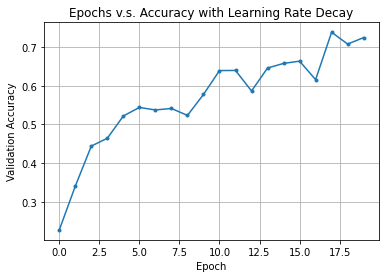

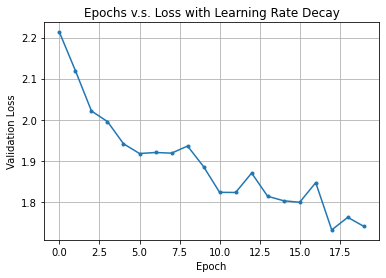

In [20]:
plt.plot(np.arange(0, 20), np.asarray(epoch_acc_decay)[:, 1], marker='.')
plt.grid(True)
plt.title("Epochs v.s. Accuracy with Learning Rate Decay")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

plt.plot(np.arange(0, 20), np.asarray(epoch_acc_decay)[:, 0], marker='.')
plt.grid(True)
plt.title("Epochs v.s. Loss with Learning Rate Decay")
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()